# BERT를 활용한 문서 분류

## 과제소개
- 문서 분류(document classification)란 문서가 주어졌을 때 해당 문서의 범주를 분류하는 과제
- 시퀀스를 입력으로 하고 범주(정치, 경제, 연예 등)를 맞추거나, 영화 리뷰가 어떤 극성(polarity, 긍정/부정 등)을 가지는지 분류하는 작업이 대표적인 예시
- 튜토리얼에서 사용할 데이터는 박은정 님이 공개한 Naver Sentiment Movie Corpus(NSMC)
- 문서 분류 모델은 다음과 같은 입/출력 형태로 구성
- 문장(영화 리뷰)을 입력, 해당 문장이 속한 범주 확률(긍정, 부정)를 출력
> 예)  
 - 진짜 짜증나네요 목소리 → [0.02, 0.98] → 부정(negative)
 - 너무재밓었다그래서보는것을추천한다 → [0.99, 0.01]→ 긍정(negative)

## 모델구조
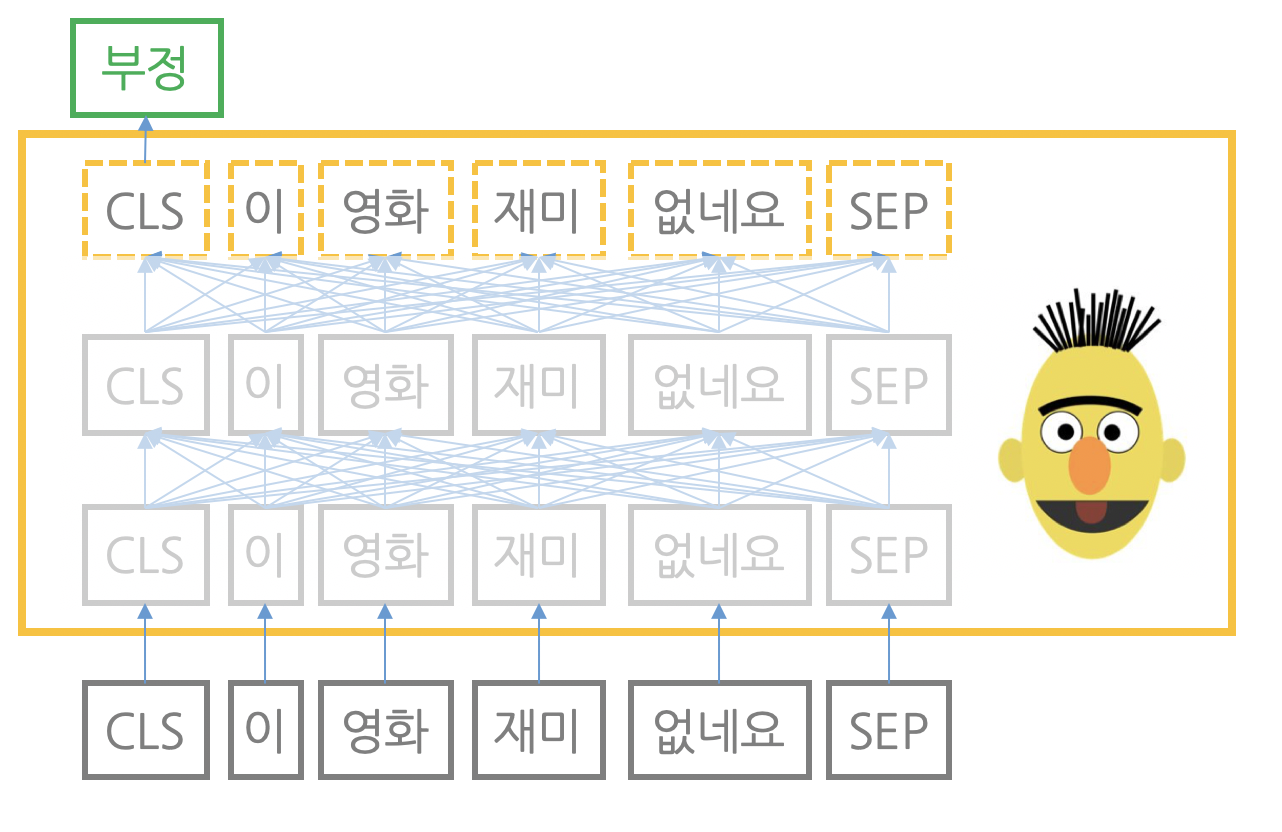

## 태스크 모듈
- CLS 벡터 뒤에 붙는 추가 모듈의 구조는 아래 그림과 같다.
- 우선 CLS 벡터에 드롭아웃(dropout)을 적용 (```x```의 768개의 요소값중 일부를 0으로 바꿔 계산에 포함하지 않음)
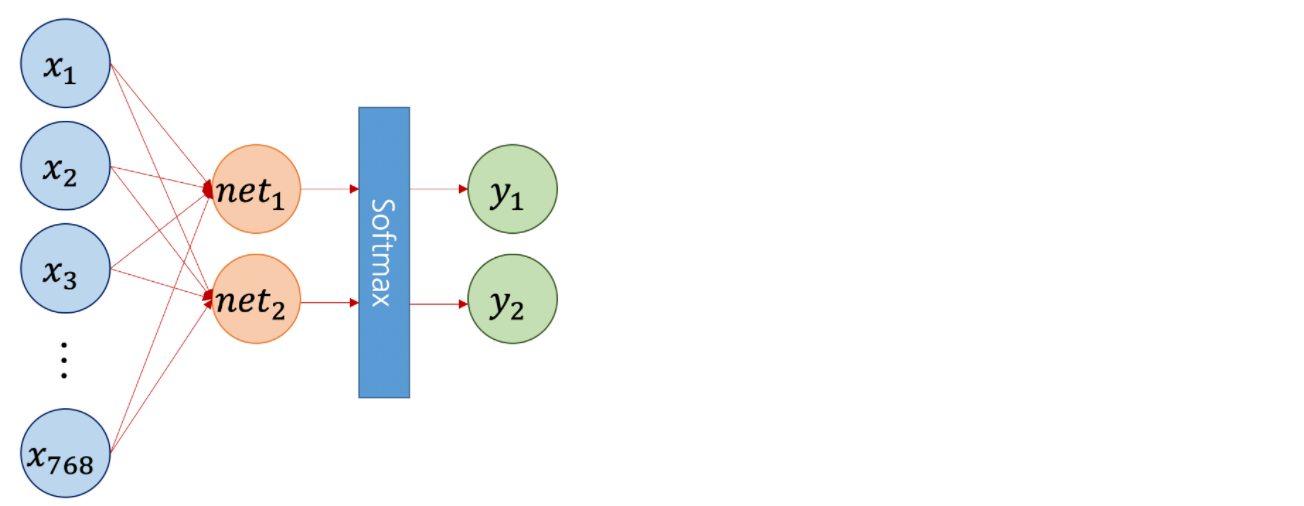

- 그 다음 가중치 행렬(weight matrix)을 곱해줘 CLS를 분류해야할 범주 수만큼의 차원을 갖는 벡터로 변환(그림에서```net```)
- 만일 CLS 벡터가 768차원이고 분류 대상 범주 수가 2개(`긍정`, `부정`)라면 가중치 행렬 크기는 768x2
- 이후 여기에 소프트맥스(softmax) 함수를 취해 준 것이 모델의 최종 출력
- 이렇게 만든 모델의 최종 출력과 정답 레이블을 비교해 모델 출력이 정답 레이블과 최대한 같아지도록 BERT 레이어 전체를 포함한 모델 전체를 업데이트 이를 `학습` 또는 `파인튜닝`이라 한다.

## 실습환경 구성
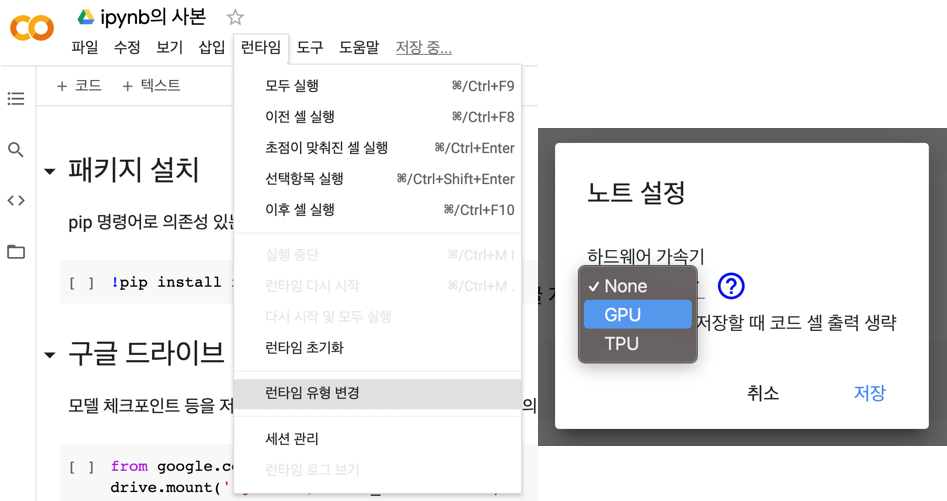

코랩 세션 유지
```javascript
function ClickConnect() {
    var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); 
    buttons.forEach(function(btn) { 
        btn.click(); 
    }); 
    console.log("1분마다 자동 재연결"); 
    document.querySelector("colab-toolbar-button#connect").click(); 
} 
setInterval(ClickConnect,1000*60);
```

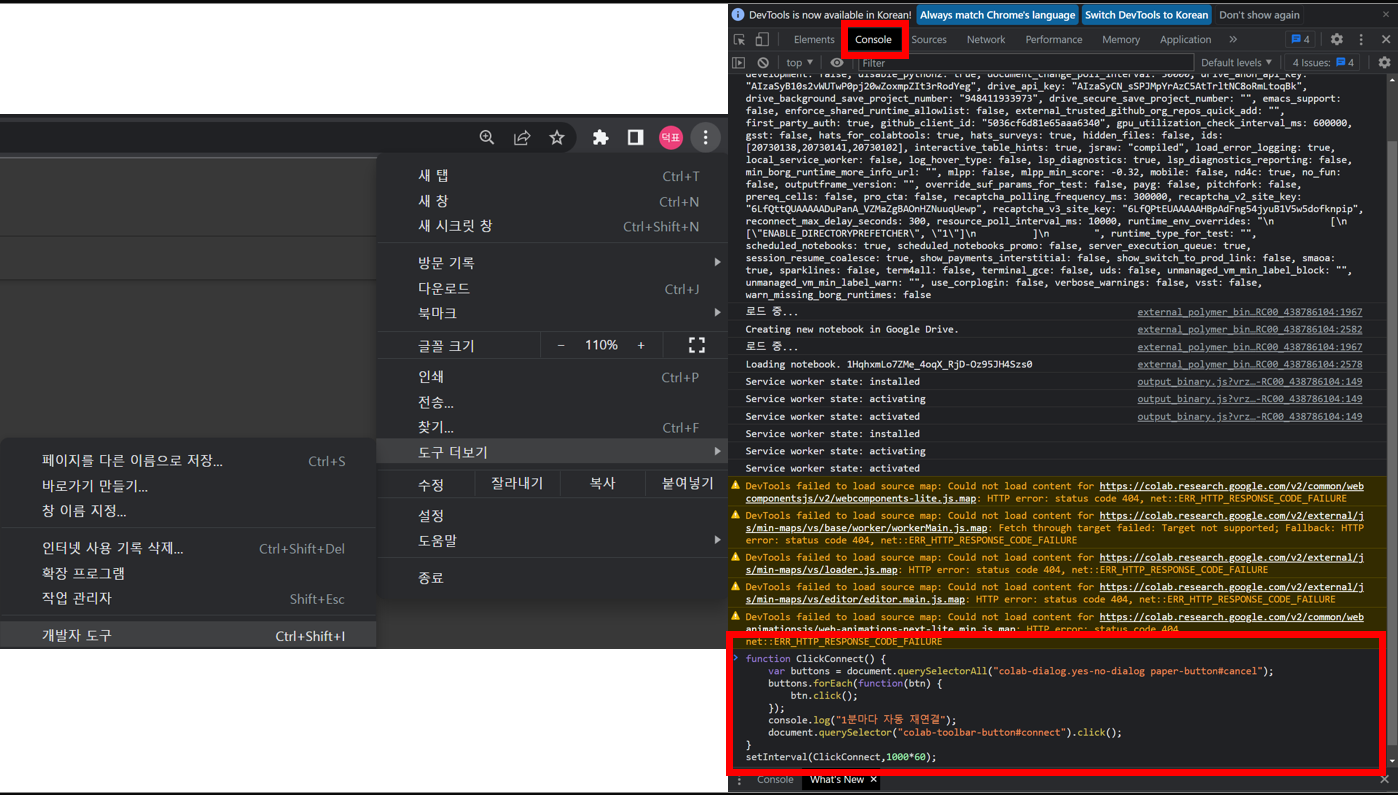

## 추가 라이브러리 설치

In [1]:
!pip install ratsnlp

     |████████████████████████████████| 42 kB 656 kB/s 
     |████████████████████████████████| 2.8 MB 16.6 MB/s 
     |████████████████████████████████| 57 kB 6.7 MB/s 
     |████████████████████████████████| 806 kB 61.3 MB/s 
     |████████████████████████████████| 636 kB 91.2 MB/s 
     |████████████████████████████████| 829 kB 66.4 MB/s 
     |████████████████████████████████| 398 kB 76.9 MB/s 
     |████████████████████████████████| 136 kB 99.3 MB/s 
     |████████████████████████████████| 895 kB 75.2 MB/s 
     |████████████████████████████████| 77 kB 7.8 MB/s 
     |████████████████████████████████| 3.3 MB 58.1 MB/s 
     |████████████████████████████████| 1.1 MB 59.8 MB/s 
     |████████████████████████████████| 96 kB 6.6 MB/s 
     |████████████████████████████████| 271 kB 93.6 MB/s 
     |████████████████████████████████| 144 kB 74.8 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sh

## 구글드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /gdrive


## 모델 환경 설정
- 이준범 님이 공개하신 kcbert-base 모델을 NSMC 데이터로 파인튜닝할 예정

In [35]:
import torch
from ratsnlp.nlpbook.classification import ClassificationTrainArguments
args = ClassificationTrainArguments(
    pretrained_model_name="beomi/kcbert-base",
    downstream_corpus_name="nsmc",
    downstream_model_dir="/content/drive/MyDrive/nlpbook/checkpoint-doccls",
    downstream_corpus_root_dir = '/content/Korpora',
    batch_size=32,
    learning_rate=5e-5,
    max_seq_length=128,
    epochs=5,
    tpu_cores=0,
    seed=7,
)

```
pretrained_model_name : 프리트레인 마친 언어모델의 이름(허깅페이스 라이브러리에 등록되어 있어야 함.)
downstream_corpus_name : 다운스트림 데이터의 이름.
downstream_model_dir : 파인튜닝된 모델의 체크포인트가 저장될 위치. 
batch_size : 배치 크기. 하드웨어 가속기로 GPU를 선택했다면 32, TPU라면 4. 
(코랩 환경에서 TPU는 보통 8개 코어가 할당되는데 batch_size는 코어별로 적용되는 배치 크기이기 때문에 이렇게 설정.)
learning_rate : 러닝레이트. 1회 스텝에서 한 번에 얼마나 업데이트할지에 관한 크기.
max_seq_length : 토큰 기준 입력 문장 최대 길이. 이보다 긴 문장은 max_seq_length로 자르고, 짧은 문장은 max_seq_length가 되도록 스페셜 토큰(PAD)을 적용.
epochs : 학습 에폭 수. 3이라면 학습 데이터를 3회 반복 학습.
tpu_cores : TPU 코어 수. 하드웨어 가속기로 GPU를 선택했다면 0, TPU라면 8.
seed : 랜덤 시드(정수, integer). None을 입력하면 랜덤 시드를 고정하지 않음.
```

In [36]:
# 랜덤 시드 고정
from ratsnlp import nlpbook
nlpbook.set_seed(args)

set seed: 7


In [37]:
# 각종 로그들을 출력하는 로거를 설정
nlpbook.set_logger(args)

INFO:ratsnlp:Training/evaluation parameters ClassificationTrainArguments(pretrained_model_name='beomi/kcbert-base', downstream_task_name='document-classification', downstream_corpus_name='nsmc', downstream_corpus_root_dir='/content/Korpora', downstream_model_dir='/content/drive/MyDrive/nlpbook/checkpoint-doccls', max_seq_length=128, save_top_k=1, monitor='min val_loss', seed=7, overwrite_cache=False, force_download=False, test_mode=False, learning_rate=5e-05, epochs=5, batch_size=32, cpu_workers=4, fp16=False, tpu_cores=0)
INFO:ratsnlp:Training/evaluation parameters ClassificationTrainArguments(pretrained_model_name='beomi/kcbert-base', downstream_task_name='document-classification', downstream_corpus_name='nsmc', downstream_corpus_root_dir='/content/Korpora', downstream_model_dir='/content/drive/MyDrive/nlpbook/checkpoint-doccls', max_seq_length=128, save_top_k=1, monitor='min val_loss', seed=7, overwrite_cache=False, force_download=False, test_mode=False, learning_rate=5e-05, epochs=

In [38]:
from Korpora import Korpora
Korpora.fetch(
    corpus_name="nsmc",
    root_dir='/content/Korpora',
    force_download=True,
)


[nsmc] download ratings_train.txt: 0.00B [00:00, ?B/s]
[nsmc] download ratings_train.txt: 14.6MB [00:00, 124MB/s]                            

[nsmc] download ratings_test.txt: 4.90MB [00:00, 60.3MB/s]


## 토크나이저 준비
- 해당 튜토리얼에서 데이터의 기본 단위는 텍스트 문장
- 토큰화(tokenization)란 문장을 토큰(token) 시퀀스로 분절하는 과정
- 이준범 님이 공개하신 kcbert-base 모델이 사용하는 토크나이저(tokenizer)를 사용.

In [39]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(
    'beomi/kcbert-base',
    do_lower_case=False,
)

## 데이터 전처리
- 딥러닝 모델을 학습하려면 학습데이터를 배치(batch) 단위로 지속적으로 모델에 공급
- 파이토치(PyTorch)에서는 이 역할을 데이터 로더(DataLoader)가 수행
- 데이터를 “문장(영화 리뷰) + 레이블(긍정, 부정)” 형태로 읽어들이는 역할

- 다시 말해 문장을 토큰화하고 이를 인덱스로 변환하는 한편, 레이블 역시 정수(integer)로 바꿔주는 역할


## ratsnlp 라이브러리 수정

/usr/local/lib/python3.7/dist-packages/ratsnlp/nlpbook/classification/corpus.py

In [40]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from ratsnlp.nlpbook.classification import NsmcCorpus, ClassificationDataset
corpus = NsmcCorpus()

In [41]:
args

ClassificationTrainArguments(pretrained_model_name='beomi/kcbert-base', downstream_task_name='document-classification', downstream_corpus_name='nsmc', downstream_corpus_root_dir='/content/Korpora', downstream_model_dir='/content/drive/MyDrive/nlpbook/checkpoint-doccls', max_seq_length=128, save_top_k=1, monitor='min val_loss', seed=7, overwrite_cache=False, force_download=False, test_mode=False, learning_rate=5e-05, epochs=5, batch_size=32, cpu_workers=4, fp16=False, tpu_cores=0)

In [42]:
train_dataset = ClassificationDataset(
    args=args,
    corpus=corpus,
    tokenizer=tokenizer,
    mode="train",
)

INFO:ratsnlp:Loading features from cached file /content/Korpora/nsmc/cached_train_BertTokenizer_128_nsmc_document-classification [took 15.471 s]
INFO:ratsnlp:Loading features from cached file /content/Korpora/nsmc/cached_train_BertTokenizer_128_nsmc_document-classification [took 15.471 s]
INFO:ratsnlp:Loading features from cached file /content/Korpora/nsmc/cached_train_BertTokenizer_128_nsmc_document-classification [took 15.471 s]


- `input_ids`, `attention_mask`, `token_type_ids`의 길이가 모두 128개로 변환
    - `input_ids`에 패딩 토큰(`[PAD]`)의 인덱스에 해당하는 0이 많이 붙어 있음을 확인
    - `attention_mask`는 해당 토큰이 패딩 토큰인지(0) 아닌지(1)
    - `token_type_ids`는 세그먼트(segment) 정보로 기본값은 모두 0
    - `label`은 정수로 변환

In [43]:
train_dataset[0]

ClassificationFeatures(input_ids=[2, 2170, 832, 5045, 17, 17, 7992, 29734, 4040, 10720, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

- `train_dataset`는 `ClassificationDataset()`로 인해 `input_ids`, `attention_mask`, `token_type_ids`,`label` 등 네가지로 변환한 형태. 즉, 인스턴스
- 데이터 로더는 `ClassificationDataset` 클래스가 들고 있는 전체 인스턴스 가운데 배치 크기(args의 batch_size)만큼 씩 배치 형태로 가공하는 역할을 수행

In [44]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    sampler=RandomSampler(train_dataset, replacement=False),
    collate_fn=nlpbook.data_collator,
    drop_last=False,
    num_workers=args.cpu_workers,
)

- `sampler`: 샘플링 방식을 정의  
- `collate_fn`:  인스턴스를 배치로 만드는 역할

In [45]:
val_dataset = ClassificationDataset(
    args=args,
    corpus=corpus,
    tokenizer=tokenizer,
    mode="test",
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=args.batch_size,
    sampler=SequentialSampler(val_dataset),
    collate_fn=nlpbook.data_collator,
    drop_last=False,
    num_workers=args.cpu_workers,
)


INFO:ratsnlp:Loading features from cached file /content/Korpora/nsmc/cached_test_BertTokenizer_128_nsmc_document-classification [took 4.750 s]
INFO:ratsnlp:Loading features from cached file /content/Korpora/nsmc/cached_test_BertTokenizer_128_nsmc_document-classification [took 4.750 s]
INFO:ratsnlp:Loading features from cached file /content/Korpora/nsmc/cached_test_BertTokenizer_128_nsmc_document-classification [took 4.750 s]


## 모델 불러오기
- `BertForSequenceClassification`은 프리트레인을 마친 BERT 모델 위에 문서 분류용 태스크 모듈이 덧붙여진 형태의 모델 클래스.
- `BertForSequenceClassification`은 허깅페이스(huggingface)에서 제공하는 transformers 라이브러리에 포함

### 모델 초기화

In [46]:
from transformers import BertConfig, BertForSequenceClassification
pretrained_model_config = BertConfig.from_pretrained(
    "beomi/kcbert-base",
    num_labels=2,
)

In [47]:
model = BertForSequenceClassification.from_pretrained(
        "beomi/kcbert-base",
        config=pretrained_model_config,
)

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

## 모델 학습 시키기
- 파이토치 라이트닝(pytorch lightning)이 제공하는 라이트닝 모듈(LightningModule) 클래스를 상속받아 태스크(task)를 정의.
- 해당 예제에서 `ClassificationTask`에 포함.
    -  옵티마이저: `Adam`
    >옵티마이저란 최적화(optimization) 알고리즘을 가리킵니다. 아담(Adam)은 널리 쓰이는 옵티마이저 가운데 하나입니다.
    - 러닝레이트 스케줄러: `ExponentialLR`
    > 모델 학습 과정은 눈을 가린 상태에서 산등성이를 한걸음씩 내려가는 과정에 비유할 수 있습니다. 러닝레이트는 한 번 내려갈 때 얼마나 이동할지 보폭에 해당합니다. 학습이 진행되는 동안 점차 러닝레이트을 줄여 세밀하게 탐색하면 좀 더 좋은 모델을 만들 수 있습니다. 이 역할을 하는 게 바로 러닝레이트 스케줄러입니다. ExponentialLR은 현재 에폭의 러닝레이트를 이전 에폭의 러닝레이트  ×  gamma로 스케줄링합니다. 우리 책 튜토리얼에선 gamma를 0.9로 정의.

### TASK 정의

In [48]:
from ratsnlp.nlpbook.classification import ClassificationTask
# TASK 정의
task = ClassificationTask(model, args)

### TRAINER 정의
- 트레이너(Trainer)를 정의.   
이 트레이너는 파이토치 라이트닝 라이브러리의 도움을 통해 GPU/TPU 설정, 로그 및 체크포인트 등 다양한 설정을 정의

In [49]:
trainer = nlpbook.get_trainer(args)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [50]:
trainer.fit(
    task,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequenceClassification | 108 M 
--------------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
435.680   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
